# Naive Bayes Modeling

This notebook will focus on using Gaussian Naive Bayes to model customer churn.

In [1]:
# import libraries
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve
from imblearn.over_sampling import SMOTENC
from sklearn.feature_selection import SelectFpr, SelectPercentile, SelectKBest

from src.seed import SEED
from src.helper import confmat, praf1

%matplotlib inline
sns.set(font_scale=1.2)

In [2]:
# load data, split data
train = pd.read_csv("../data/processed/train.csv")
X = train.iloc[:, :-1]
y = train.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, stratify=y)

## Vanilla Modeling

In [3]:
# create instance, fit data, and make predictions
nb = GaussianNB()
nb.fit(X_train, y_train)

train_pred = nb.predict(X_train)
test_pred = nb.predict(X_test)

In [4]:
# output results
a = praf1(y_train, train_pred, "Training")
b = praf1(y_test, test_pred, "Testing")
pd.concat([a, b])

,precision,recall,accuracy,f1
Training,0.183043,0.852399,0.428495,0.30137
Testing,0.161364,0.780220,0.377600,0.26742


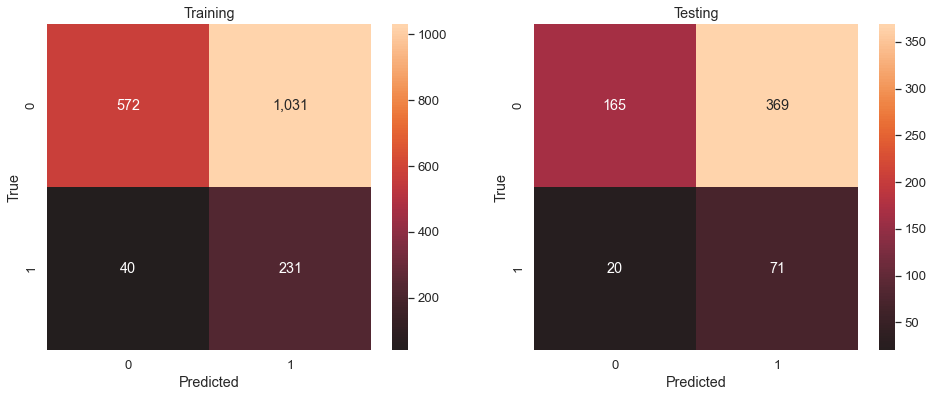

In [5]:
# confusion matrix
confmat([y_train, y_test], [train_pred, test_pred], ["Training", "Testing"])
plt.show()

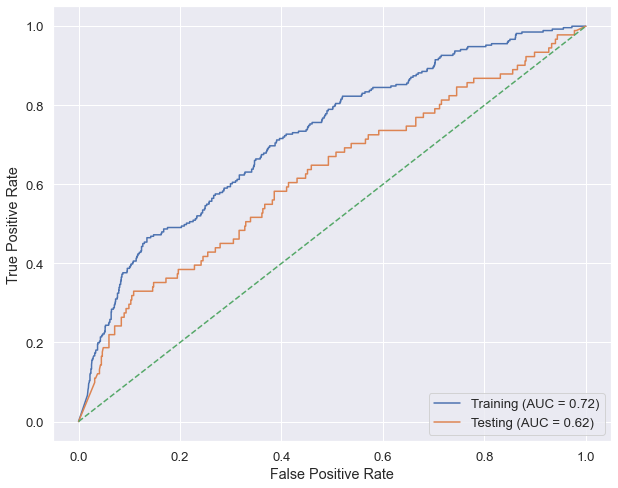

In [6]:
# output roc/auc curve
fig, ax = plt.subplots(figsize=(10, 8))
plot_roc_curve(nb, X_train, y_train, name="Training", ax=ax)
plot_roc_curve(nb, X_test, y_test, name="Testing", ax=ax)

line = np.linspace(0, 1)
plt.plot(line, line, "--")

plt.show()

Our basic model with class imbalance not accounted for, has accuracy below random guessing (50/50 chance) for both our training and testing sets. Although our recall is high, it is at the cost of precision.

Future models should look into removing unnecessary features, and accounting for class imbalance.

## Class Imbalance

To tune our model, we'll first start off by balancing out our classes.

In [7]:
# use SMOTENC to account for class imbalance
sm = SMOTENC(np.arange(19, 69), random_state=SEED, n_jobs=-1)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [8]:
# create instance, fit data, and make predictions
nb1 = GaussianNB()
nb1.fit(X_train, y_train)

train_pred = nb1.predict(X_train)
test_pred = nb1.predict(X_test)

In [9]:
# output results
a = praf1(y_train, train_pred, "Training")
b = praf1(y_test, test_pred, "Testing")
pd.concat([a, b])

,precision,recall,accuracy,f1
Training,0.908673,0.862757,0.888022,0.88512
Testing,0.173913,0.131868,0.782400,0.15000


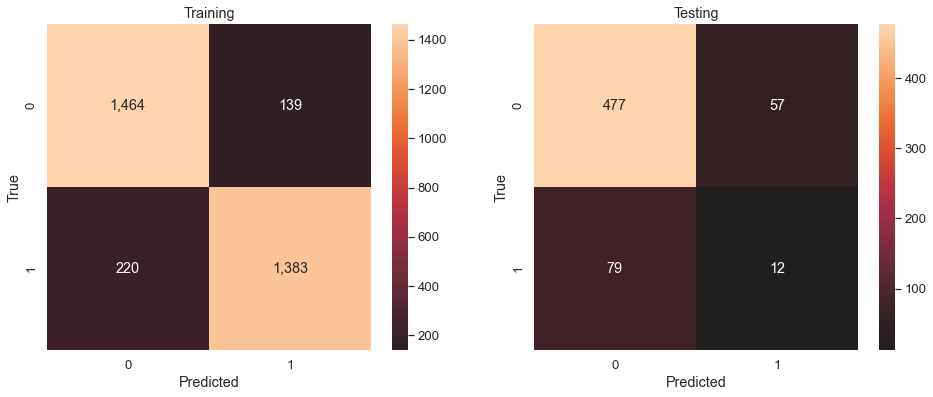

In [10]:
# confusion matrix
confmat([y_train, y_test], [train_pred, test_pred], ["Training", "Testing"])
plt.show()

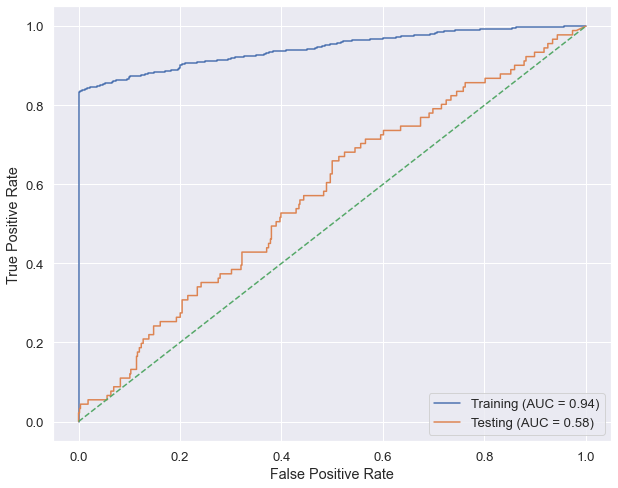

In [11]:
# output roc/auc curve
fig, ax = plt.subplots(figsize=(10, 8))
plot_roc_curve(nb1, X_train, y_train, name="Training", ax=ax)
plot_roc_curve(nb1, X_test, y_test, name="Testing", ax=ax)

line = np.linspace(0, 1)
plt.plot(line, line, "--")

plt.show()

Adjusting for class imbalance has lead to a model which performs well on training data, but testing data is still lackluster. Our accuracy in both training and testing has adjusted to above 50%, making it better than random chance, however we see low precision and low recall.

## Feature Selection

To expand our model and see if we can make it perform better, we'll look to reducing our feature set. Since we don't have l1 or l2 regularization like in logistic regression it'll take a little more effort to do feature selection. 

The feature selection classes that will be used, use the f_classif function, this function computes the ANOVA F-value for the provided sample between classes. For a classification task such as ours, that means it'll compute the value between the churn classes. It examines each feature individually to determine the strength of the relationship of the feature with the response variable.

In [12]:
# iteratively train models with different feature sets and find train/test scores
scores = []
for feats in np.arange(1, X_train.shape[1] + 1):
    selector = SelectKBest(k=feats)
    selection = selector.fit_transform(X_train, y_train)
    train_score = cross_val_score(GaussianNB(), selection, y_train, scoring="f1", n_jobs=-1).mean()
    test_score = cross_val_score(GaussianNB(), selector.transform(X_test), y_test, scoring="f1", n_jobs=-1).mean()
    scores.append((feats, train_score, test_score))

In [13]:
# find the optimal feature size with a good testing score
feat_df = pd.DataFrame(scores, columns=["feats", "train_score", "test_score"])
feat_df.sort_values("test_score", ascending=False).head()

,feats,train_score,test_score
5,6,0.805740,0.523066
4,5,0.811186,0.477539
3,4,0.773843,0.468109
6,7,0.722144,0.464863
7,8,0.699696,0.463055


In [14]:
# what are the best 6 features
selector = SelectKBest(k=6)
selector.fit(X_train, y_train)

X_train.columns[selector.get_support()]

Index(['international_plan', 'voice_mail_plan', 'number_vmail_messages',
       'day_minutes', 'day_charge', 'customer_service_calls'],
      dtype='object')

In [15]:
# adjust our X_train, and X_test 
X_train_fs = selector.fit_transform(X_train, y_train)
X_test_fs = selector.transform(X_test)

In [16]:
# fit and predict with our new model
nb_fs = GaussianNB()
nb_fs.fit(X_train_fs, y_train)

train_pred = nb_fs.predict(X_train_fs)
test_pred = nb_fs.predict(X_test_fs)

In [17]:
# output results
a = praf1(y_train, train_pred, "Training")
b = praf1(y_test, test_pred, "Testing")
pd.concat([a, b])

,precision,recall,accuracy,f1
Training,0.796240,0.819089,0.804741,0.807503
Testing,0.372881,0.725275,0.782400,0.492537


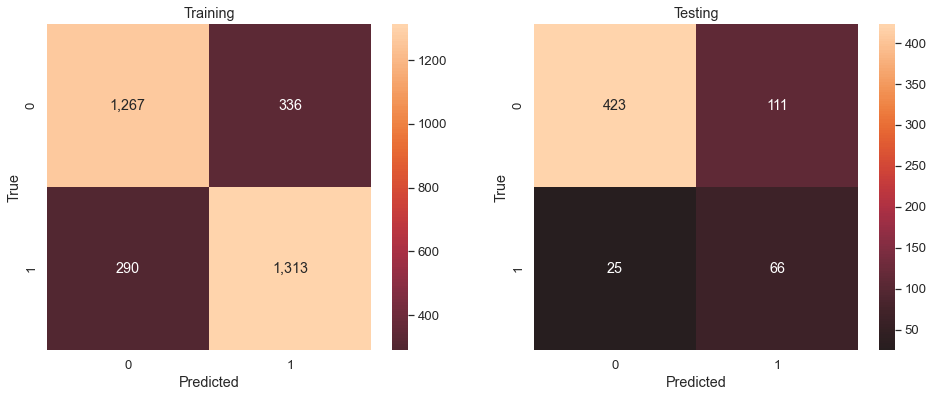

In [18]:
confmat([y_train, y_test], [train_pred, test_pred], ["Training", "Testing"])

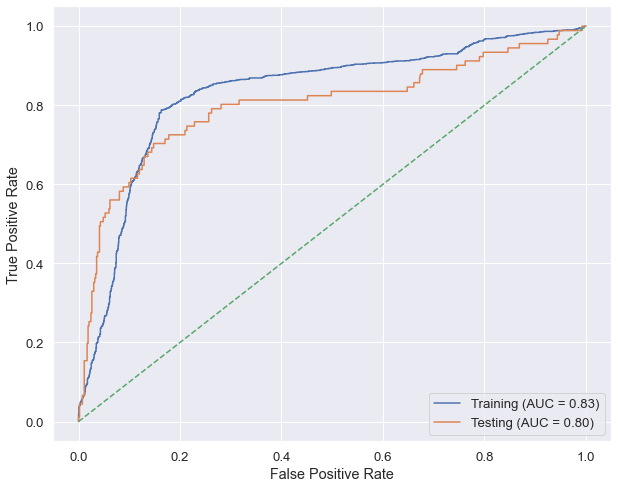

In [19]:
# output roc/auc curve
fig, ax = plt.subplots(figsize=(10, 8))
plot_roc_curve(nb_fs, X_train_fs, y_train, name="Training", ax=ax)
plot_roc_curve(nb_fs, X_test_fs, y_test, name="Testing", ax=ax)

line = np.linspace(0, 1)
plt.plot(line, line, "--")

plt.show()

With just 6 features, we see an immense improvement in our model, our f1 score is now almost .5, and our accuracy in both training and testing shows promising results. Our precision is still lackluster, hitting almost 40% in tests, but our recall is well in the 70% range in tests.

Based on tests our model is still misclassifying about 28% of customers who will soon about to leave (recall), and approximately 60% of the positive predictions are actually incorrect (precision).